# Gebiedsregeling Kruislandse Kreken, SOBEK -> RTC
In deze notebook wordt een begin gemaakt aan het omzetten van het SOBEK-model naar een RTC model.

# Afvoer en bui-bestanden
De afvoer is SOBEK wordt bepaald door de relationele methode (oppervlakte * intisiteit). De oppervlaktes zijn niet representatief voor de werkelijke oppervlaktes, hier zitten ook versleutelingen in die oa. rekening houden met hoe nat of droog een gebied is, de intentisiteiten zijn door analyse van gemeten afvoeren bepaald. Door de oppervlaktes te aggregeren per nodes kan er per node een afvoer worden bepaald. In deze afvoer zit nog geen vervorming of vertraging, er dient nog bekeken te worden of dat benodigd is (ik denk het wel).

In [1]:
import hkvsobekpy as hkv
bui = hkv.read_bui("data//bui-bestanden//CKT10.bui") # bui-bestand, in deze map zitten bestanden voor afvoeren met een herhalingstijd van 10 tot 100 jaar
# het buibestand bevat twee stations, Station2 is representatief voor het vrij afwaterende deel, Station1 voor het peilbeheerste deel.
bui.head(2)

,Station1,Station2
2013-01-01 00:00:00,0.0052,0.003707
2013-01-01 00:30:00,0.0052,0.003707


In [2]:
import pandas as pd
lat = pd.read_csv("data//LATERAL.DAT", sep=" ", header=None, usecols=[2,14,19], names=["id", "station", "area"]) # dit bestand bevat de geschaalde oppervlaktes per
# afwatereenheid, en welk station in het buibestand gebruikt moet worden
lat = lat.dropna(subset=['area']) # paar rijen met andersoortige data verwijderen
lat.id = lat.id.str.replace("'", "").str[3:] # SOBEK-opmaak aanpassen zodat hij matcht aan de afwatereenheden shapefile
lat.station = lat.station.str.replace("'", "")
lat.head(2)

,id,station,area
0,VA00030_178,Station2,2.438155e+06
1,VA00030_230,Station2,1.099188e+06


In [3]:
import geopandas as gpd
afwatereenh = gpd.read_file("data//shp//afwatereenheden.shp") # afwatereenheden zijn de geo representatie van de lateralen, stellen een afwaterend gebied op een A-water voor
afwatereenh = afwatereenh[afwatereenh.node != 999] # bevat alle afwatereenheden voor hele beheersgebied van wsbd, selecteer alleen geclassificeerde afwatereenh.
afwatereenh.head(2)

,OBJECTID,GPGIDENT,GAFIDENT,GAFNAAM,GPG_BRON,GPG_DATUM,COMPWAT,XCOORD,YCOORD,STUDIEGEBI,...,SOURCE,WINTERPEIL,ZOMERPEIL,GEBIED,GPGNAAM,GPG_CODE,SHAPE_AREA,SHAPE_LEN,node,geometry
2058,2418,VA00030_230,VA00030_230,None,None,None,0.0,82840.872834,392621.738124,CRUKRE,...,None,0.0,0.0,None,None,None,0.0,0.0,9,"POLYGON ((82728.404 392975.508, 82801.120 3929..."
2059,2419,VA00030_231,VA00030_231,None,None,None,0.0,82871.246028,393303.134732,CRUKRE,...,None,0.0,0.0,None,None,None,0.0,0.0,9,"POLYGON ((82728.404 392975.508, 82738.003 3929..."


In [4]:
nodes = gpd.read_file("data//shp//nodes.shp") # nodes zijn de punten waar de afvoer op het systeem komt, samen met de kunstwerken vormen ze de basis voor het netwerk
nodes.head(2)

,Id,geometry
0,0,POINT (84299.729 389835.483)
1,1,POINT (84472.968 390331.400)


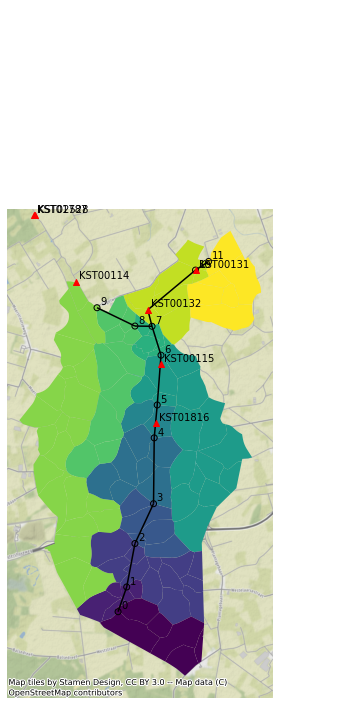

In [17]:
import contextily as ctx
from shapely.geometry import LineString

ax = afwatereenh.plot(column="node", figsize=(11,9)) # afwaterende gebieden
nodes.plot(ax=ax, edgecolor="black", column="Id") # gedefineerde nodes corresponderen, met afwaterende gebieden
ctx.add_basemap(ax, crs=afwatereenh.crs.to_string()) # achtergrondje

stuwen = gpd.read_file("data/shp/stuwen.shp")
stuwen.plot(ax=ax, marker="^", zorder=999, color="red")

lines = [LineString([node, nodes.geometry[i+1]]) for i, node in enumerate(nodes.geometry) if i < 9]
lines.extend([LineString([nodes.geometry[7], stuwen[stuwen.CODE == "KST00132"].geometry.iloc[0]])])
lines.extend([LineString([stuwen[stuwen.CODE == "KST00132"].geometry.iloc[0], nodes.geometry[10]])])
lines.extend([LineString([nodes.geometry[10], nodes.geometry[11]])])
gpd.GeoDataFrame(geometry=lines).plot(ax=ax, color="black") # verbindende lijnen (waterlopen)

for x, y, label in zip(nodes.geometry.x, nodes.geometry.y, nodes.Id):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

for x, y, label in zip(stuwen.geometry.x, stuwen.geometry.y, stuwen.CODE):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

ax.axis("off");

In [6]:
calc = afwatereenh.merge(lat, left_on="GPGIDENT", right_on="id")
calc = pd.DataFrame(calc.groupby(['node', 'station'])['area'].sum()).reset_index() # totaaloppervlak per node en station
calc

,node,station,area
0,0,Station2,1.505015e+07
1,1,Station2,4.191145e+06
2,2,Station2,2.113435e+07
3,3,Station2,1.439533e+07
4,4,Station2,1.945805e+07
5,5,Station2,6.251454e+06
6,6,Station2,4.792641e+07
7,7,Station1,2.394231e+06
8,7,Station2,9.627051e+05
9,8,Station1,4.523919e+06


<AxesSubplot:>

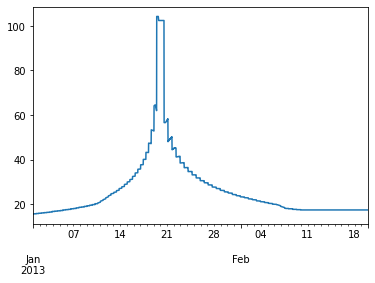

In [11]:
(calc.at[0, "area"] * bui["Station2"] / 3600).plot() # afvoer in l/s voor node 0